In [101]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
from scipy.sparse import csc_matrix
import time
import warnings

In [42]:
class Params:
    '''
    example: params=Params(g=1,ED=433)
    '''
    def __init__(self,
        a=np.array([1e-10,1e-10,1e-10]), # lattice constant in m
        L=np.array([25e-10,25e-10,50e-10]),   # System size in m
        m=1,    # m_e, where m_e is 0.511 MeV
        E_F=11, # Chemical potential of Al in eV
        E_z=0,  # Zeeman field in eV
        g=10,   # Coupling strength in eV
        E_D=433,    # Debye temperature in K
        T=0,    # Temperature in eV      
        variance=0,     # variance of disorder in eV
        periodic_boundary_condition=1 # 1: periodic boundary condition
        ):
        self.a=np.array(a)*5.076e6    # eV^-1
        self.L=np.array(L)*5.076e6    # eV^-1
        self.m=m*0.511e6    # eV
        self.E_F=E_F        # eV
        self.E_z=E_z        # eV
        self.g=g            # eV
        self.E_D=E_D*8.617333262e-5       # eV
        self.T=T            # eV
        self.variance=variance  # eV
        self.periodic_boundary_condition=periodic_boundary_condition


        self.N=np.rint(self.L/self.a).astype(int)    # Number of grids in the real-sapce mesh
        self.s0=np.array([[1,0],[0,1]])
        self.sx=np.array([[0,1],[1,0]])
        self.sy=np.array([[0,-1j],[1j,0]])
        self.sz=np.array([[1,0],[0,-1]])
        self.b=2*np.pi/self.a    # reciprocal unit vector in eV
        self.t=1/(2*self.m*self.a*self.a)    # NN hopping in eV
        self.disorder=self.variance*np.random.randn(self.N[0],self.N[1])    # disorder profile
        self.Delta=np.zeros((self.N[0],self.N[1]))  
        self.wfall=[[] for _ in range(self.N[2])]
        self.energyall=[[] for _ in range(self.N[2])]    


    def energy_kz(self):
        kindex=np.arange(self.N[2])
        uz=(2*kindex-self.N[2]+1)/(2*self.N[2])
        self.kzlist=uz*self.b[2]    # eV^-1
        self.energylist=2*self.t[2]*(1-np.cos(self.a[2]*self.kzlist))   # eV
        return self.energylist
    
    def estimate_k(self):
        k_request=np.zeros(self.N[2])
        for kzindex in range(self.N[2]):
            kxindex=np.arange(self.N[0])
            kyindex=np.arange(self.N[1])        
            ux=(2*kxindex-self.N[0]+1)/(2*self.N[0])
            uy=(2*kyindex-self.N[1]+1)/(2*self.N[1])
            kxlist=ux*self.b[0]
            kylist=uy*self.b[1]
            kz=self.kzlist[kzindex]
            [kxgrid,kygrid]=np.meshgrid(kxlist,kylist)
            Emesh=2*self.t[0]*(1-np.cos(kxgrid*self.a[0]))\
                +2*self.t[1]*(1-np.cos(kygrid*self.a[1]))\
                +2*self.t[2]*(1-np.cos(kz*self.a[2]))-self.E_F
            k_request[kzindex]=4*np.count_nonzero((Emesh<self.E_D) & (Emesh>-self.E_D))
        self.k_request=k_request.astype(int)
        return self.k_request
    
    def Fermi_dist(self):
        self.F_D=[1./(np.exp(np.array(energy)/self.T)+1) if len(energy)>0 else [] for energy in self.energyall]
        return self.F_D


In [43]:
def make_bare_Al(param,kzindex):
    lat=kwant.lattice.Monatomic(((param.a[0],0),(0,param.a[1])))
    syst= kwant.Builder()
    for x in range(param.N[0]):
        for y in range(param.N[1]):
            syst[lat(x,y)]=(2*param.t[0]+2*param.t[1]+param.energylist[kzindex]-param.E_F+param.disorder[x,y])*np.kron(param.sz,param.s0)+(param.Delta[x,y])*np.kron(param.sy,param.sy)
    syst[kwant.builder.HoppingKind((1, 0), lat, lat)]=-param.t[0]*np.kron(param.sz,param.s0)
    syst[kwant.builder.HoppingKind((0, 1), lat, lat)]=-param.t[1]*np.kron(param.sz,param.s0)
    syst[((lat(0,j),lat(param.N[0]-1,j)) for j in range(param.N[1]))]=-param.t[0]*np.kron(param.sz,param.s0)*param.periodic_boundary_condition
    syst[((lat(j,0),lat(j,param.N[1]-1)) for j in range(param.N[0]))]=-param.t[1]*np.kron(param.sz,param.s0)*param.periodic_boundary_condition
    return syst.finalized()


In [96]:
def energyMF(param):
    '''
    diagonlization of the mean-field Hamiltonian
    '''
    start_time=time.time()
    k_request_nz,=np.where(param.k_request[:param.N[2]//2]!=0)   # take out the nonzero index
    for kindex in k_request_nz:
        # kindex=k_request_nz[k_request_nz_index]        
        k_req=param.k_request[kindex]
        k_req=np.max([40,2*(1.1*k_req//2).astype(int)])
        syst=make_bare_Al(param,kindex)
        H_bdg=syst.hamiltonian_submatrix()
        H_bdg=csc_matrix(np.real((H_bdg+H_bdg.T.conj())/2))
        if len(param.energyall[kindex])>0:
            val,vec=sla.eigsh(H_bdg,k=k_req,sigma=0,v0=param.wfall[kindex][:,0])
        else:
            val,vec=sla.eigsh(H_bdg,k=k_req,sigma=0)
        
        print('kindex={},min(val)={:e},max(val)={:e},'.format(kindex,np.min(np.abs(val)),np.max(np.abs(val))))

        # restart with 2*k_req
        while np.max(val)<param.E_D:
            print('k ({}) is too small, restart with k ({})'.format(k_req,k_req*2))
            k_req=k_req*2
            if len(param.energyall[kindex])>0:
                val,vec=sla.eigsh(H_bdg,k=k_req,sigma=0,v0=param.wfall[kindex][:,0])
            else:
                val,vec=sla.eigsh(H_bdg,k=k_req,sigma=0)
        
        debyeindex=(np.abs(val)<=param.E_D)
        val=val[debyeindex]
        vec=vec[:,debyeindex]

        sortindex=np.argsort(val)
        val=val[sortindex]
        vec=vec[:,sortindex]
        print('len(val)={}'.format(val.shape[0]))

        param.energyall[kindex]=val
        param.energyall[param.N[2]-kindex-1]=val
        param.wfall[kindex]=vec
        param.wfall[param.N[2]-kindex-1]=vec
    print('Elapsed time is: {:.1f}s'.format(time.time()-start_time))

In [45]:
def ave(param):
    '''
    Taking average of 1/2 1/Nz*sum_kz c_{r,-k,down} c_{r,k,up}
    '''
    param.ave=np.zeros((param.N[0]*param.N[1]))
    param.Fermi_dist()    
    for kindex in range(param.N[2]):
        if len(param.energyall[kindex])>0:
            wf=param.wfall[kindex].reshape((param.N[0]*param.N[1],4,-1))
            param.ave+=(wf[:,3,:].conj()*wf[:,0,:]-wf[:,2,:].conj()*wf[:,1,:])@param.F_D[kindex]
    
    param.ave=param.ave/(2*param.N[2])
    param.Delta=param.g*param.ave.reshape((param.N[0],param.N[1]))

In [46]:
def iter(initial,param):
    '''
    Iterations to find self-consistent solution
    '''
    param.Delta=initial*np.ones((param.N[0],param.N[1]))
    Deltalist=[param.Delta]
    energyMF(param)    
    for i in range(1000):
        ave(param)
        print('-'*10+'Iteration: {}, Average Delta: {:e} eV'.format(i,param.Delta.mean())+'-'*10)
        Deltalist+=[param.Delta]
        if np.abs(Deltalist[i].mean()-Deltalist[i-1].mean())<1e-8:
            break
        energyMF(param)

In [97]:
p=Params(L=[25e-10,25e-10,50e-10],E_D=50*433,periodic_boundary_condition=0)
p.energy_kz()
p.estimate_k()

iter(2e-2,p)

kindex=6,min(val)=1.905,max(val)=2.720,
len(val)=0
kindex=7,min(val)=1.170,max(val)=1.985,
len(val)=32
kindex=8,min(val)=0.365,max(val)=2.092,
len(val)=76
kindex=9,min(val)=0.063,max(val)=2.443,
len(val)=120
kindex=10,min(val)=0.053,max(val)=1.985,
len(val)=172
kindex=11,min(val)=0.053,max(val)=2.012,
len(val)=208
kindex=12,min(val)=0.031,max(val)=1.840,
k (218) is too small, restart with k (436)
len(val)=224
kindex=13,min(val)=0.073,max(val)=1.953,
len(val)=228
kindex=14,min(val)=0.104,max(val)=1.880,
len(val)=244
kindex=15,min(val)=0.050,max(val)=2.050,
len(val)=248
kindex=16,min(val)=0.061,max(val)=1.941,
len(val)=248
kindex=17,min(val)=0.057,max(val)=1.935,
len(val)=264
kindex=18,min(val)=0.025,max(val)=1.817,
k (284) is too small, restart with k (568)
len(val)=288
kindex=19,min(val)=0.027,max(val)=1.911,
len(val)=304
kindex=20,min(val)=0.024,max(val)=1.815,
k (318) is too small, restart with k (636)
len(val)=332
kindex=21,min(val)=0.021,max(val)=1.718,
k (318) is too small, restar

KeyboardInterrupt: 

In [32]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '0.013720508545789972')

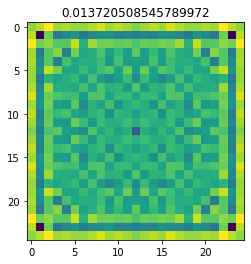

In [98]:
fig,ax=plt.subplots()
ax.imshow(p.Delta)
ax.set_title(p.Delta.mean())